# Fiber Assignment Efficiency

Look for variations in fiber-assignment efficiency for neighbors of non-functional robots, depending on how well tucked they are and if they have an expanded keepout.

Use the [fiberassign-TILEID.fits.gz files](https://desidatamodel.readthedocs.io/en/latest/DESI_TARGET/fiberassign/tiles/TILES_VERSION/TILEXX/fiberassign-TILEID.html) for the authoritative information on fiber assignment success and run date. Use [tiles-SPECPROD.html](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/tiles-SPECPROD.html) for a list of all tiles.

In [1]:
%matplotlib inline

In [84]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fitsio

In [361]:
import astropy.time

In [356]:
import fpoffline.array
import fpoffline.io
import fpoffline.const

In [39]:
FA_PATH = Path('/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/')
assert FA_PATH.exists()

In [121]:
REDUX = Path(f'/global/cfs/cdirs/desi/spectro/redux/')
assert REDUX.exists()

In [192]:
def get_tile_rundates(outfile='tile-rundates.csv', maxlines=100):
    
    token = 'rundate='
    k0 = len(token)
    with open(outfile, 'w') as out:
        print('tileid,rundate', file=out)
        for group in sorted(FA_PATH.glob('???')):
            try:
                nnn = int(group.name)
                print(f'Scanning {group.name}nnn...')
            except ValueError:
                # silently ignore any other subdirs
                pass
            for logfile in sorted(group.glob(f'fiberassign-{group.name}???.log')):
                tileid = int(logfile.name[12:18])
                with open(logfile, 'r') as f:
                    found = False
                    for i in range(maxlines):
                        line = f.readline()
                        k = line.find(token)
                        if k >= 0:
                            start = line[k+k0:]
                            if start[10] != 'T':
                                print(f'Missing iso T on line {i} of {logfile}: {start[:19]}')
                            try:
                                timestamp = pd.Timestamp(start[:19], tz='UTC')
                            except Exception:
                                print(f'Invalid RUNDATE on line {i} of {logfile}: {start[:19]}')
                                break
                            found = True
                            break
                    if not found:
                        print(f'No RUNDATE found in {logfile}')
                        continue
                print(f'{tileid},"{timestamp}"', file=out)

%time get_tile_rundates()

Scanning 000nnn...
Scanning 001nnn...
Scanning 002nnn...
Scanning 003nnn...
Scanning 004nnn...
Scanning 005nnn...
Scanning 006nnn...
Scanning 007nnn...
Scanning 008nnn...
Scanning 009nnn...
Scanning 010nnn...
Scanning 011nnn...
Scanning 020nnn...
Scanning 021nnn...
Scanning 022nnn...
Scanning 023nnn...
Scanning 024nnn...
Scanning 025nnn...
Scanning 026nnn...
Scanning 027nnn...
Scanning 040nnn...
Scanning 041nnn...
Scanning 042nnn...
Scanning 043nnn...
Scanning 059nnn...
Scanning 060nnn...
Scanning 063nnn...
Scanning 065nnn...
Scanning 066nnn...
Scanning 067nnn...
Scanning 068nnn...
Scanning 070nnn...
Scanning 074nnn...
Scanning 078nnn...
Scanning 080nnn...
Scanning 081nnn...
Scanning 082nnn...
Scanning 083nnn...
CPU times: user 1.62 s, sys: 2.42 s, total: 4.04 s
Wall time: 4min 27s


In [193]:
df = pd.read_csv('tile-rundates.csv', index_col='tileid', parse_dates=['rundate'])

In [222]:
breaks = [
    pd.Timestamp(date, tz='UTC') for date in
    ('2021-09-01', '2022-08-01', '2023-08-01', '2024-05-01', pd.Timestamp.now())
]

In [300]:
def load_snapshots():
    
    snaps = [ ]
    for when in breaks:
        snap = fpoffline.io.get_snapshot(timestamp=astropy.time.Time(when.to_pydatetime()), maxage_days=60)
        snaps.append(snap)
    return snaps

snaps = load_snapshots()

Loaded 14260 tiles for survey "main"


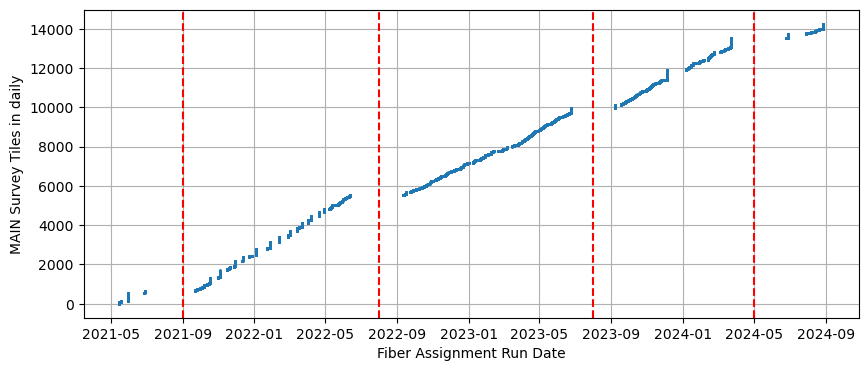

In [198]:
def get_tile_info(release='kibo', survey='main'):
    
    # read the rundates for each tile design
    df = pd.read_csv('tile-rundates.csv', index_col='tileid')
    df.rundate = pd.to_datetime(df.rundate, format='ISO8601')
    
    # load the tile metadata for the requested survey
    path = REDUX / release
    assert path.exists()
    fitspath = path / f'tiles-{release}.fits'
    csvpath = path / f'tiles-{release}.csv'
    if fitspath.exists():
        tiles = fitsio.read(str(fitspath), ext=1)
        sel = tiles['SURVEY'] == survey
        tiles = pd.DataFrame(tiles[sel].byteswap().newbyteorder())
    elif csvpath.exists():
        tiles = pd.read_csv(csvpath)
        sel = tiles.SURVEY == survey
        tiles = tiles[sel]
    else:
        print(f'No tiles file found for release "{release}"')
        return
    print(f'Loaded {len(tiles)} tiles for survey "{survey}"')

    # add the rundate column
    tiles['RUNDATE'] = df.loc[tiles.TILEID,'rundate'].to_numpy()
    
    # sort by rundate
    tiles.sort_values('RUNDATE', inplace=True, ignore_index=False)

    fig, ax = plt.subplots(figsize=(10, 4))
    n = np.arange(len(tiles))
    ax.plot(tiles.RUNDATE, n, '.', ms=2)
    ax.set(xlabel='Fiber Assignment Run Date', ylabel=f'{survey.upper()} Survey Tiles in {release}')
    ax.grid()
    
    for t in breaks:
        ax.axvline(t, c='r', ls='--')
    
    return tiles
    
tile_info = get_tile_info(release='daily')

In [199]:
tile_info[tile_info.TILEID == 42118]

TILEID SURVEY PROGRAM FAPRGRM    FAFLAVOR  NEXP  EXPTIME   TILERA  \
10531   42118   main  backup  backup  mainbackup     1    433.1  261.405   

       TILEDEC  EFFTIME_ETC  ...  GOALTIME  OBSSTATUS  LRG_EFFTIME_DARK  \
10531   33.499         61.3  ...      60.0     obsend              65.2   

      ELG_EFFTIME_DARK  BGS_EFFTIME_BRIGHT  LYA_EFFTIME_DARK  GOALTYPE  \
10531             70.1                67.9              32.8    backup   

       MINTFRAC LASTNIGHT                   RUNDATE  
10531      0.85  20230530 2023-05-30 17:00:39+00:00  

[1 rows x 22 columns]

In [258]:
def load_tile(tileid):
    
    tag = str(tileid).zfill(6)
    path = FA_PATH / tag[:3] / f'fiberassign-{tag}.fits.gz'
    with fitsio.FITS(str(path)) as hdus:
        hdr = hdus[0].read_header()
        when = pd.Timestamp(hdr['RUNDATE'])
        info = hdus['FIBERASSIGN'][['PETAL_LOC','DEVICE_LOC','OBJTYPE']].read()
        unassigned = info[info['OBJTYPE'] != 'TGT']
        locations = np.sort(1000 * unassigned['PETAL_LOC'] + unassigned['DEVICE_LOC'])
        return when, locations
        
#load_tile(42118)

In [259]:
RUNS = (RUN1, RUN2, RUN3, RUN4)

In [261]:
def get_tile_stats(info):
    
    counts = [ ]
    stop = breaks[0]
    for i, run in enumerate(RUNS):
        start = stop
        stop = breaks[i+1]
        sel = (info.RUNDATE >= start) & (info.RUNDATE < stop)
        tiles = info[sel]
        n = len(tiles)
        print(f'Loading {n} tiles designed from {start} to {stop}')
        counts.append(n)
    return counts
        
counts = get_tile_stats(tile_info)

Loading 4874 tiles designed from 2021-09-01 00:00:00+00:00 to 2022-08-01 00:00:00+00:00
Loading 4423 tiles designed from 2022-08-01 00:00:00+00:00 to 2023-08-01 00:00:00+00:00
Loading 3577 tiles designed from 2023-08-01 00:00:00+00:00 to 2024-05-01 00:00:00+00:00
Loading 723 tiles designed from 2024-05-01 00:00:00+00:00 to 2024-09-22 16:48:43.925532+00:00


In [223]:
def load_tiles(info, start, stop):
    
    sel = (info.RUNDATE >= start) & (info.RUNDATE < stop)
    tiles = info[sel]
    
    FP = fpoffline.array.DeviceArray()

    n = 0
    for _, row in tiles.iterrows():

        # Read the fiberassign FITS file
        when, locations = load_tile(row.TILEID)

        # Verify that the rundates agree
        delta = abs(when - row.RUNDATE)
        if delta.days > 1:
            print(f'RUNDATEs do not match for {row.TILEID}: {when} , {row.RUNDATE}')

        # Accumulate statistics
        FP[locations] += 1

        n += 1
        if n % 500 == 0:
            print(f'read {n} tiles')
            
    # Normalize to unassigned fractions
    FP.data /= n

    return FP

In [203]:
%time RUN1 = load_tiles(tile_info, breaks[0], breaks[1])

read 500 tiles
read 1000 tiles
read 1500 tiles
read 2000 tiles
read 2500 tiles
read 3000 tiles
read 3500 tiles
read 4000 tiles
read 4500 tiles
CPU times: user 10min 8s, sys: 5.9 s, total: 10min 14s
Wall time: 13min 26s


In [204]:
np.save('RUN1.npy', RUN1.data)

In [205]:
%time RUN2 = load_tiles(tile_info, breaks[1], breaks[2])

read 500 tiles
read 1000 tiles
read 1500 tiles
read 2000 tiles
read 2500 tiles
read 3000 tiles
read 3500 tiles
read 4000 tiles
CPU times: user 8min 48s, sys: 5.02 s, total: 8min 53s
Wall time: 11min 45s


In [206]:
np.save('RUN2.npy', RUN2.data)

In [207]:
%time RUN3 = load_tiles(tile_info, breaks[2], breaks[3])

read 500 tiles
read 1000 tiles
read 1500 tiles
read 2000 tiles
read 2500 tiles
read 3000 tiles
read 3500 tiles
CPU times: user 7min 10s, sys: 4.02 s, total: 7min 14s
Wall time: 9min 32s


In [208]:
np.save('RUN3.npy', RUN3.data)

In [209]:
%time RUN4 = load_tiles(tile_info, breaks[3], pd.Timestamp.now(tz='UTC'))

read 500 tiles
CPU times: user 1min 32s, sys: 1.03 s, total: 1min 33s
Wall time: 2min 1s


In [210]:
np.save('RUN4.npy', RUN4.data)

In [289]:
def get_nonfunctional(snap):
    
    locs = 1000 * snap['PETAL_LOC'] + snap['DEVICE_LOC']
    nonfunc = snap['DEVICE_CLASSIFIED_NONFUNCTIONAL']
    return np.sort(np.asarray(locs[nonfunc]))

In [437]:
def get_neighbors(max_neighbors=6, max_separation=12, sentinel_value=-1):
    
    design = fpoffline.const.get_petal_design()
    X, Y = design.holes.X_PTL.to_numpy(), design.holes.Y_PTL.to_numpy()
    dX = X.reshape(-1,1) - X
    dY = Y.reshape(-1,1) - Y
    separation = np.hypot(dX, dY)
    is_neighbor = (separation > 0) & (separation < max_separation)
    neighbors = np.full((len(X), max_neighbors), sentinel_value, int)
    for i, row in enumerate(is_neighbor):
        locs = np.flatnonzero(row)
        neighbors[i, :len(locs)] = locs
    return neighbors
    
neighbors = get_neighbors(sentinel_value=457) # = FP.locmap[461] = DEVICE_LOC of ETC fiber

In [408]:
def get_data(start, stop=None):
    
    if stop is None:
        stop = start + 1
    
    # Combine data over [start:stop]
    ntot = 0
    FP = fpoffline.array.DeviceArray(POS=True, ETC=True)    
    for i in range(start, stop):
        n = counts[i]
        ntot += n
        FP.data += n * RUNS[i].data        
    FP.data /= ntot
    
    # Identify non-functional robots at start and stop.
    nonfunc_before = set(get_nonfunctional(snaps[start][0]))
    nonfunc_after = set(get_nonfunctional(snaps[stop][0]))

    title = f'{ntot} tiles from {breaks[start].date()} to {breaks[stop].date()}'

    return FP, nonfunc_before, nonfunc_after, title

In [467]:
def show_neighbors(loc, snap = snaps[-1][0]):
    
    design = fpoffline.const.get_petal_design()
    petal_loc = loc // 1000
    device_loc = loc % 1000
    idx = design.locmap[device_loc]
    neighbor_locs = 1000 * petal_loc + design.holes.DEVICE_LOC.to_numpy()[neighbors[idx]]
    
    snap_locs = 1000 * snap['PETAL_LOC'] + snap['DEVICE_LOC']
    
    row = snap[snap_locs == loc][0]
    print(row['POS_ID'])
    print(sorted(row['POS_NEIGHBORS']))
    
    neighbor_posids = [ ]
    neighbor_nonfunc = [ ]
    for loc in neighbor_locs:
        if loc in snap_locs:
            neighbor_posids.append(snap[snap_locs == loc][0]['POS_ID'])
            neighbor_nonfunc.append(snap[snap_locs == loc][0]['DEVICE_CLASSIFIED_NONFUNCTIONAL'])
        else:
            print(f'Missing loc {loc} in snapshot')
    neighbor_posids = np.array(neighbor_posids)
    neighbor_isfunc = ~np.array(neighbor_nonfunc)
    isort = np.argsort(neighbor_posids)
    print(list(neighbor_posids[isort]))
    print(neighbor_isfunc[isort])
    return np.count_nonzero(neighbor_isfunc)

show_neighbors(1342)

M05399
['M03858', 'M03998', 'M04207', 'M04782', 'M04977']
Missing loc 1321 in snapshot
['M03858', 'M03998', 'M04207', 'M04782', 'M04977']
[False  True False  True  True]


3

In [590]:
def get_retracted_locs(snap=snaps[-1][0]):
    
    locs = 1000 * snap['PETAL_LOC'] + snap['DEVICE_LOC']
    sel = snap['CLASSIFIED_AS_RETRACTED']
    return np.array(locs[sel])

retracted_locs = get_retracted_locs()

In [591]:
retracted_locs

array([7050, 3436])

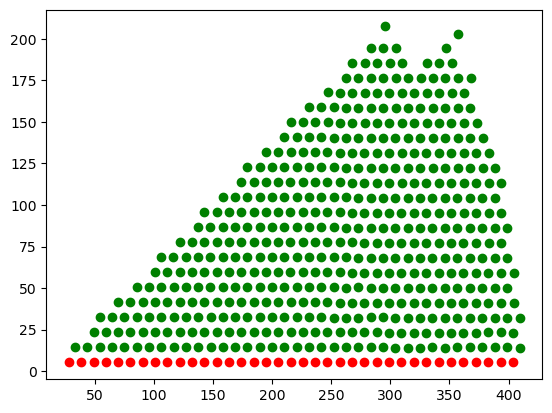

In [513]:
def get_edge_locs():
    
    design = fpoffline.const.get_petal_design()
    x_ptl, y_ptl = design.holes.X_PTL.to_numpy(), design.holes.Y_PTL.to_numpy()
    y0 = np.min(y_ptl)
    is_edge = y_ptl < y0 + 1
    plt.plot(x_ptl[~is_edge], y_ptl[~is_edge], 'go')
    plt.plot(x_ptl[is_edge], y_ptl[is_edge], 'ro')
    edge_locs = design.holes.DEVICE_LOC[is_edge].to_numpy()
    return edge_locs
    
edge_locs = get_edge_locs()

In [581]:
def plot_frac(start, stop=None, exclude_edges=True, save=None):
    
    FP, nonfunc_before, nonfunc_after, title = get_data(start, stop)
    
    # Exclude robots that are non-functional at either end of this period
    nonfunc_any = list(nonfunc_before | nonfunc_after)
    FP[nonfunc_any] = np.nan
    
    # Exclude fiducials
    design = fpoffline.const.get_petal_design()
    fiducials = design.holes.DEVICE_LOC[np.isin(design.holes.DEVICE_TYPE, ('FIF','GIF'))].to_numpy()
    FP.data[:, FP.locmap[fiducials]] = np.nan
    
    num_functional_neighbors = np.zeros((10, 514), int)
    for petal_loc in range(10):
        # Count the number of functional neighbors of each robot for this petal
        is_neighbor_functional = np.isfinite(FP.data[petal_loc, neighbors])
        num_functional_neighbors[petal_loc] = np.count_nonzero(is_neighbor_functional, axis=1)
        
    # Do not include non-functional robots in the histograms
    num_functional_neighbors[~np.isfinite(FP.data)] = -1

    if exclude_edges:
        # Do not include edge robots in the histograms
        k = FP.locmap[edge_locs]
        num_functional_neighbors[:, k] = -1
        # Save the fractions for functional edge robots to plot later
        edge_data = FP.data[:, k].ravel()
        edge_data = edge_data[np.isfinite(edge_data)]

    fig, ax = plt.subplots(figsize=(8, 5))
    bins = np.linspace(0, 8, 41)
    groups = {
        'n<4': [ (1,2,3), dict(histtype='step', hatch='///', color='C0', alpha=0.75) ],
        'n=4': [ (4,), dict(histtype='step', color='C1', lw=2) ],
        'n=5': [ (5,), dict(histtype='step', color='C2', lw=2) ],
        'n=6': [ (6,), dict(histtype='stepfilled', color='C3', alpha=0.15) ],
    }
    ntot = 0
    for label, group in groups.items():
        nums, kwargs = group
        # Find robots with exactly n functional neighbors
        ploc, pidx = np.where(np.isin(num_functional_neighbors, nums))
        ngroup = len(ploc)
        ntot += ngroup
        print(f'Plotting {ngroup} robots with {label}')
        data = 100 * FP.data[ploc, pidx].ravel()
        mu = np.mean(data)
        ax.hist(data, bins=bins, label=f'{label} mean {mu:.1f}%', **kwargs)
        
    if exclude_edges:
        # Plot the edge robots as a separate category
        n = len(edge_data)
        print(f'Plotting {n} robots on petal edges')
        mu = np.mean(100*edge_data)
        ax.hist(100*edge_data, bins=bins, label=f'edges mean {mu:.1f}%', histtype='step',
                hatch='||||', color='r', alpha=0.5)
        
    print(f'Plotted {ntot} total robots')
    ax.set(xlabel = 'Fiber assignment failure rate [%]', ylabel='Fibers with functional robots',
           xlim=(bins[0],bins[-1]), ylim=(0,220))
    ax.legend()
    plt.tight_layout()
    if save:
        plt.savefig(save)

Plotting 682 robots with n<4
Plotting 973 robots with n=4
Plotting 1367 robots with n=5
Plotting 1156 robots with n=6
Plotted 4178 total robots


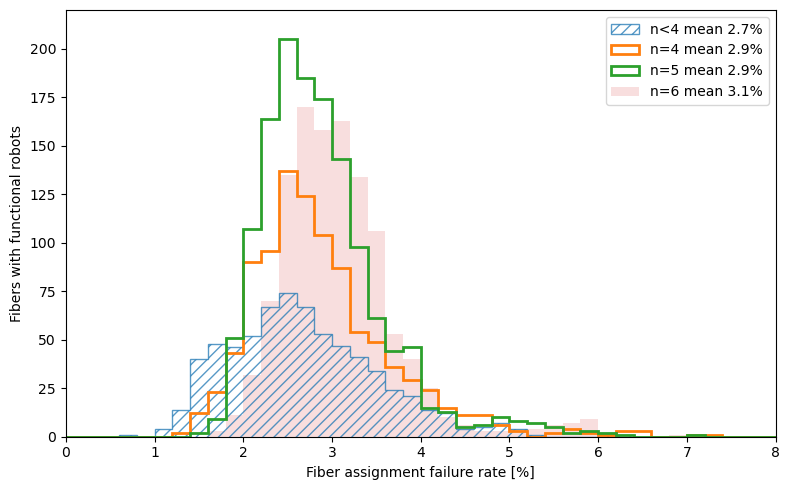

In [571]:
plot_frac(2, exclude_edges=False, save='frac1.jpg')

Plotting 516 robots with n<4
Plotting 805 robots with n=4
Plotting 1367 robots with n=5
Plotting 1156 robots with n=6
Plotting 334 robots on petal edges
Plotted 3844 total robots


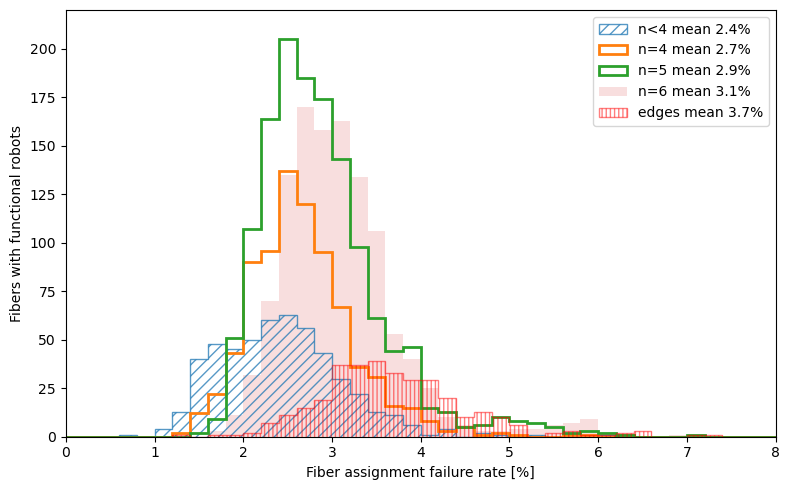

In [582]:
plot_frac(2, exclude_edges=True, save='frac2.jpg')

In [583]:
def plot_unassigned(start, stop=None, vmin=0.01, vmax=0.1, show_edges=False, save=None):
    
    FP, nonfunc_before, nonfunc_after, title = get_data(start, stop)
    print(title)
    
    nonfunc_any = list(nonfunc_before | nonfunc_after)
    nonfunc_throughout = list(nonfunc_before & nonfunc_after)
    nonfunc_new = list(nonfunc_after - nonfunc_before)
    nonfunc_recovered = list(nonfunc_before - nonfunc_after)
    print(f'Non-functional: {len(nonfunc_before)} before, {len(nonfunc_after)} after, ' +
          f'{len(nonfunc_throughout)} throughout, {len(nonfunc_new)} new, {len(nonfunc_recovered)} recovered')
    
    # Identify fiducials
    design = fpoffline.const.get_petal_design()
    fiducials = FP.locmap[design.holes.DEVICE_LOC[np.isin(design.holes.DEVICE_TYPE, ('FIF','GIF'))].to_numpy()]
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set(aspect=1, xlim=(-420,420), ylim=(-420,420))
    ax.axis('off')
    
    # Plot unassigned fractions for robots that were functional throughout
    x, y = FP.xy()
    FP[nonfunc_any] = np.nan
    FP.data[:,fiducials] = np.nan
    ax.scatter(x, y, c=FP.data, lw=0, s=40, cmap='plasma_r', vmin=vmin, vmax=vmax)
    
    # Plot blue dots for fiducials
    ax.scatter(x[:,fiducials], y[:,fiducials], s=4, c='b')
    
    # Plot black x for robots that are non-functional throughout
    k = FP._decode(nonfunc_throughout)
    ax.scatter(x[k], y[k], marker='x', s=12, c='k', lw=0.5)
    
    # Plot red x for robots that became non-functional during [start:stop]
    k = FP._decode(nonfunc_new)
    ax.scatter(x[k], y[k], marker='x', s=12, c='r', lw=0.5)
    
    # Plot green x for initially non-func robots that were recovered during [start:stop]
    k = FP._decode(nonfunc_recovered)
    ax.scatter(x[k], y[k], marker='x', s=12, c='limegreen', lw=0.5)
    
    if show_edges:
        # Draw black outlines around petal edge robots
        k = FP.locmap[edge_locs]
        ax.scatter(x[:,k], y[:,k], s=45, facecolors='none', edgecolors='k', lw=0.5)
    
    plt.tight_layout()
    if save:
        plt.savefig(save)

4874 tiles from 2021-09-01 to 2022-08-01
Non-functional: 759 before, 770 after, 679 throughout, 91 new, 80 recovered


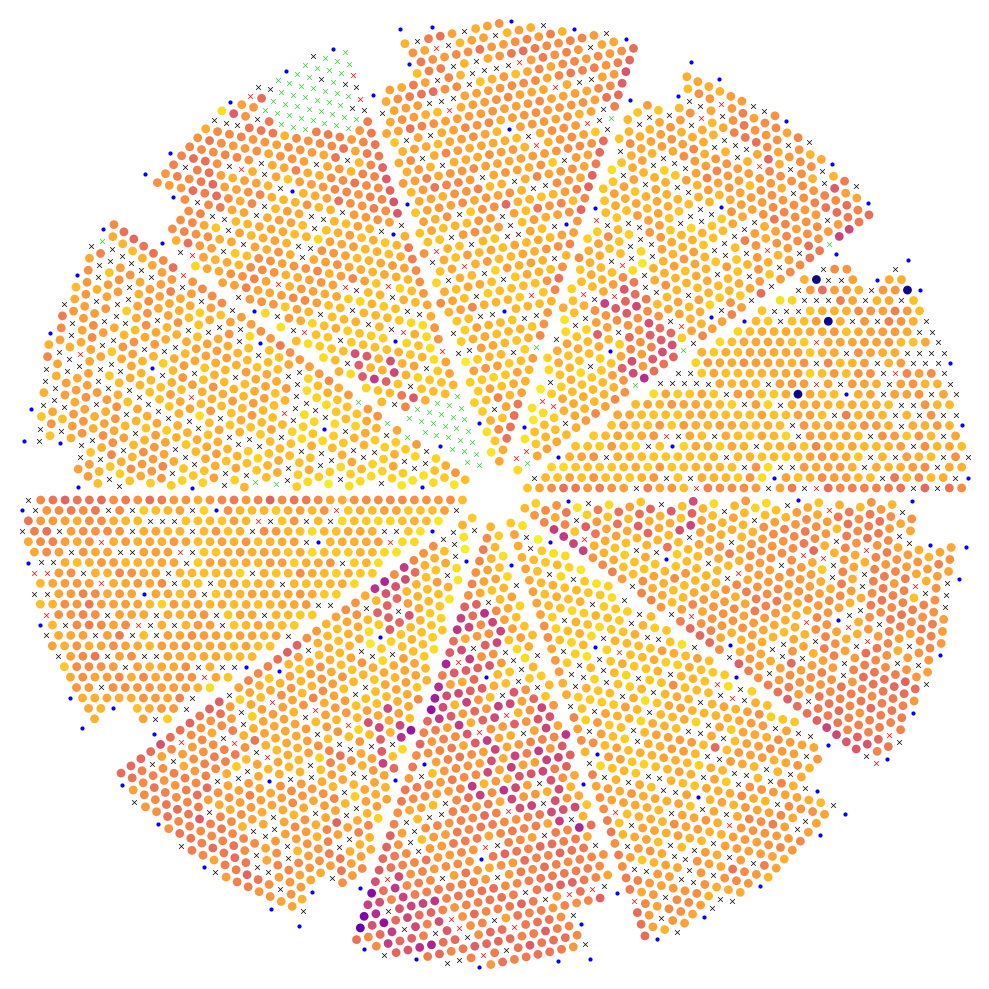

In [584]:
plot_unassigned(0, save='RUN1.jpg')

4423 tiles from 2022-08-01 to 2023-08-01
Non-functional: 770 before, 814 after, 770 throughout, 44 new, 0 recovered


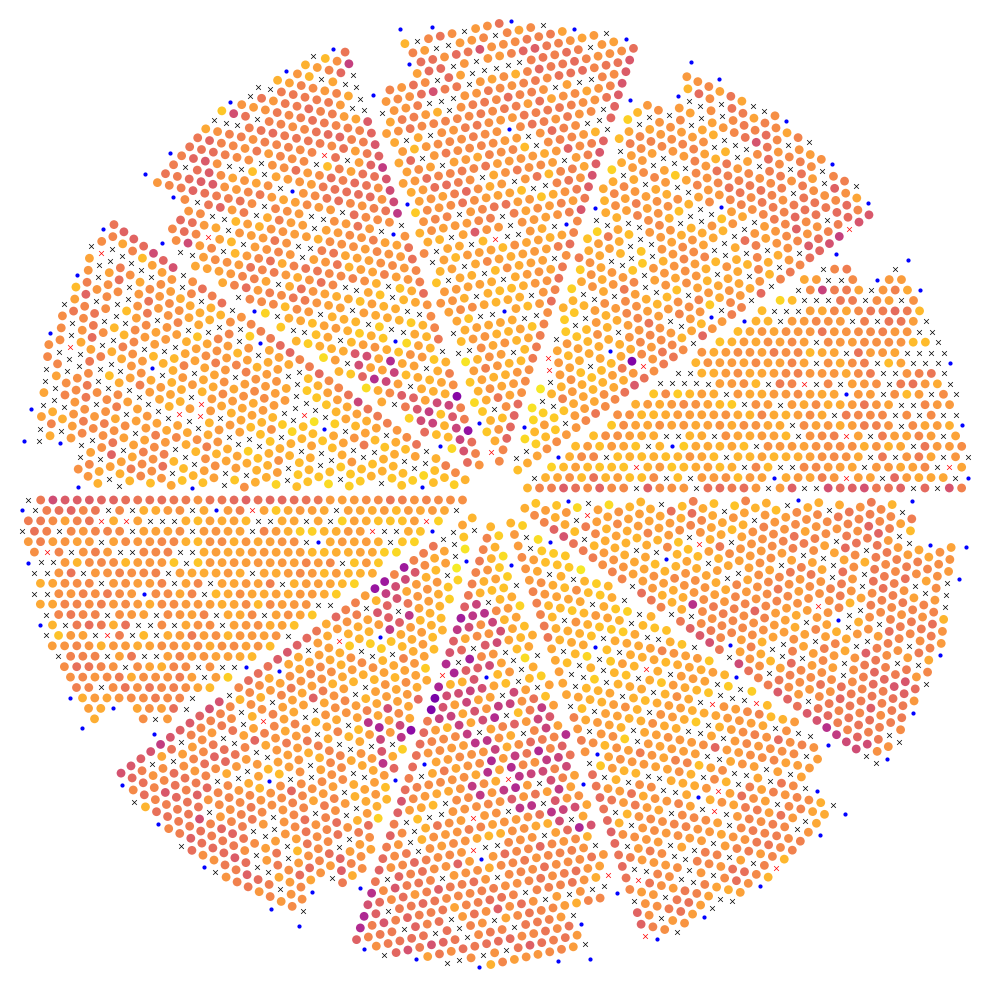

In [585]:
plot_unassigned(1, save='RUN2.jpg')

3577 tiles from 2023-08-01 to 2024-05-01
Non-functional: 814 before, 840 after, 814 throughout, 26 new, 0 recovered


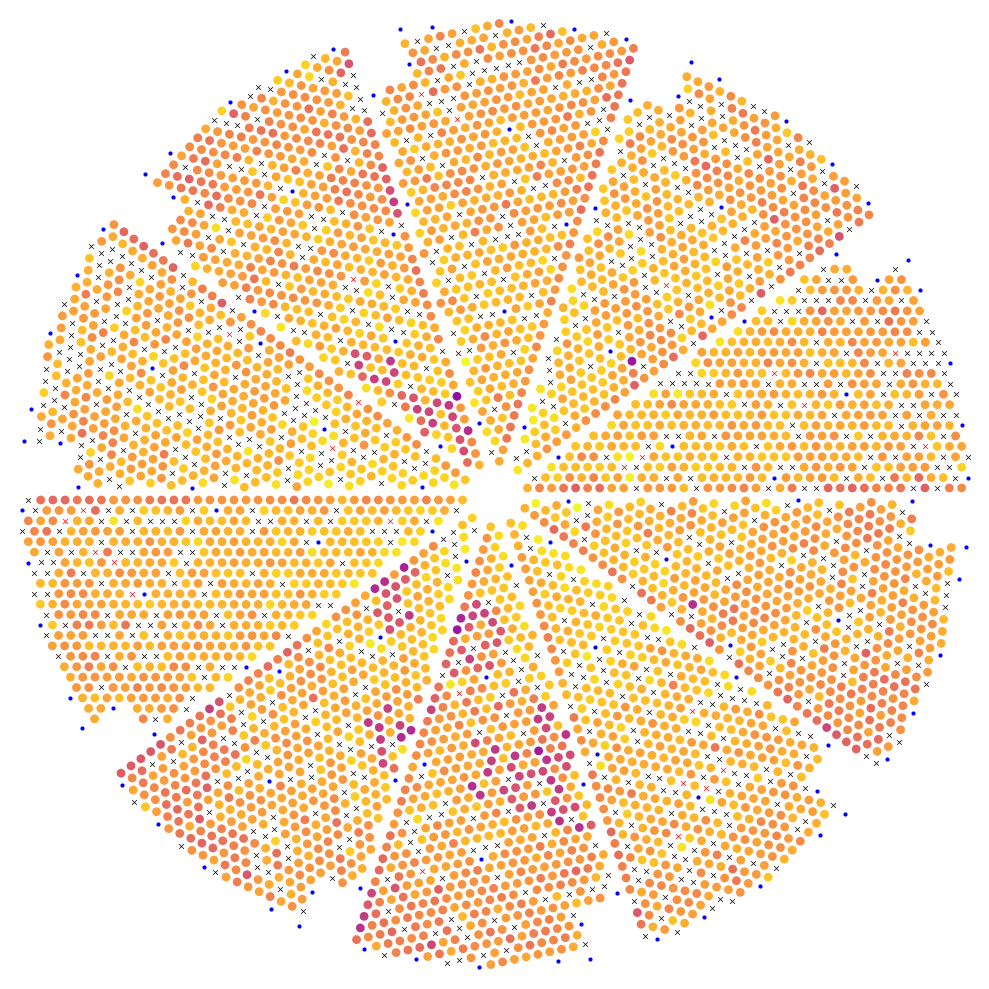

In [586]:
plot_unassigned(2, save='RUN3.jpg')

723 tiles from 2024-05-01 to 2024-09-22
Non-functional: 840 before, 621 after, 615 throughout, 6 new, 225 recovered


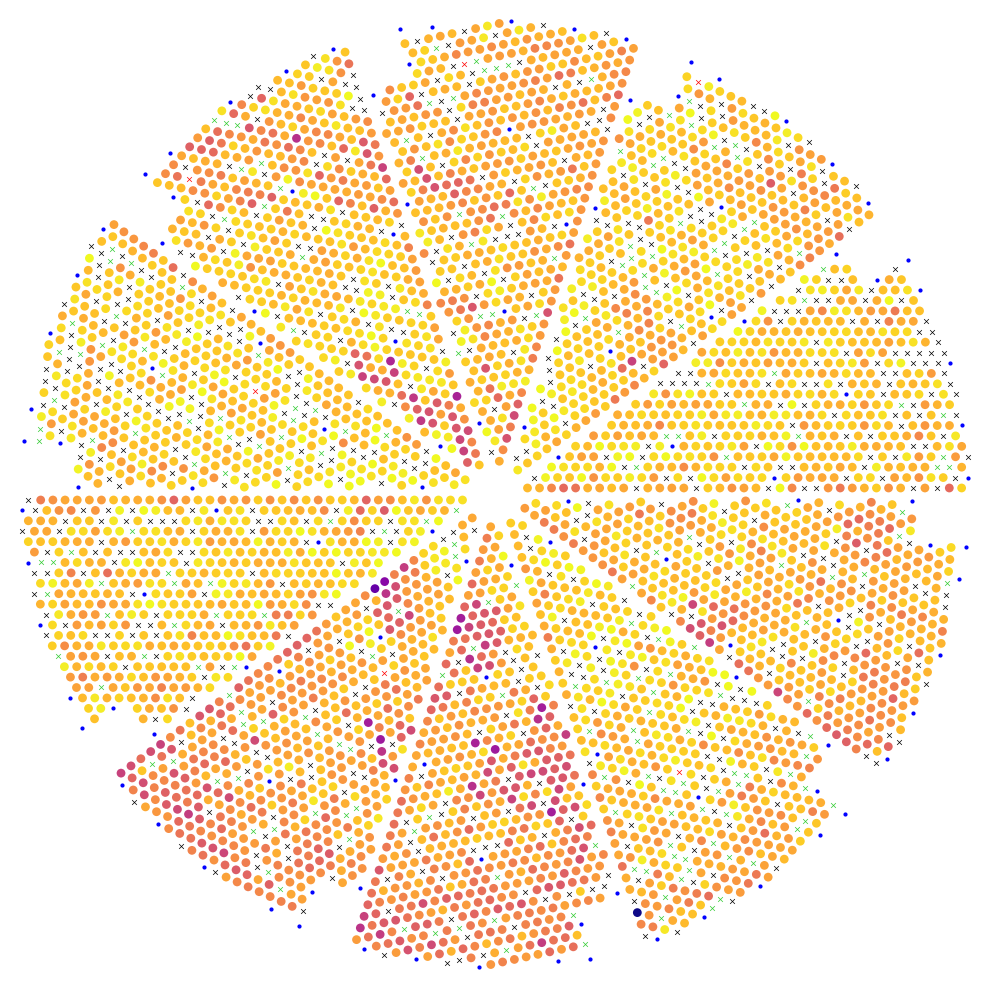

In [587]:
plot_unassigned(3, save='RUN4.jpg')

13597 tiles from 2021-09-01 to 2024-09-22
Non-functional: 759 before, 621 after, 473 throughout, 148 new, 286 recovered


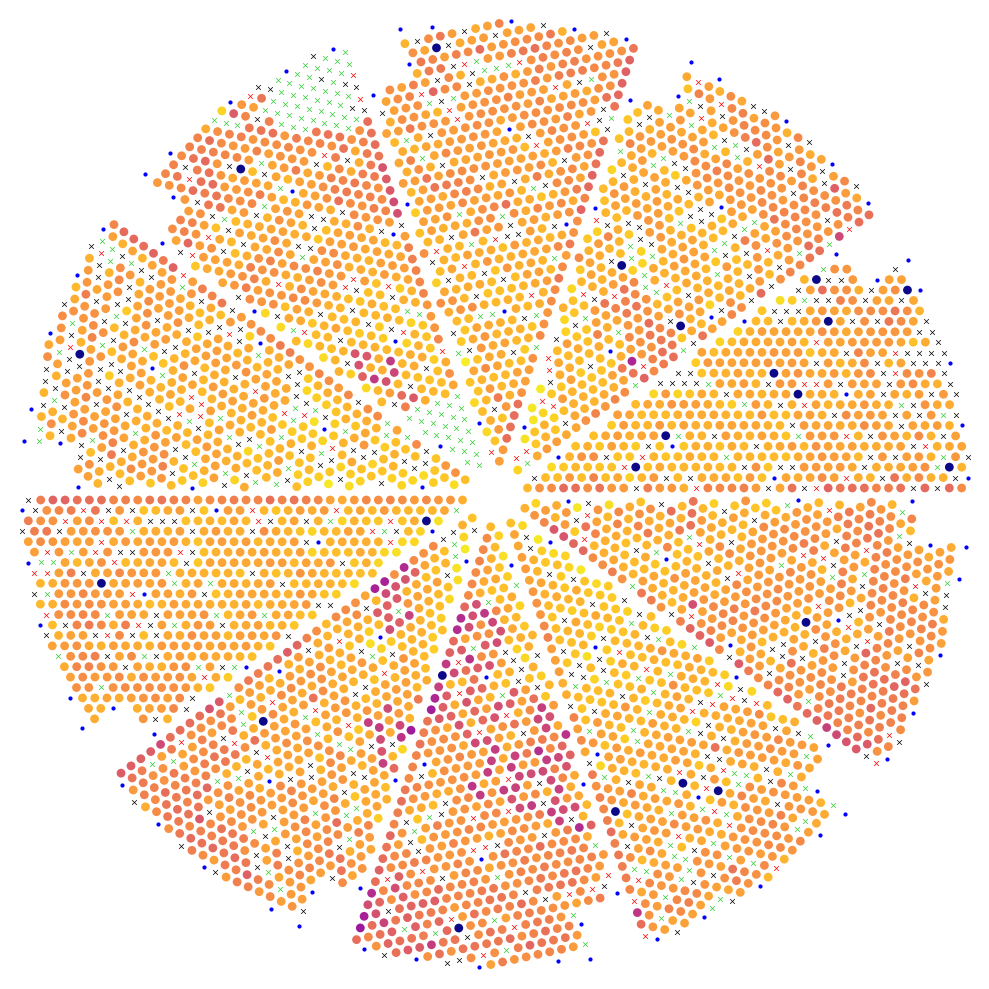

In [588]:
plot_unassigned(0, 4, save='ALLRUNS.jpg')

Outlier robot in P4 is M0533 = L4073 = F2470

In [592]:
RUN2.data[4, RUN2.locmap[73]]

0.07664481121410807